In [1]:
import numpy as np
import random
import scipy as sp
import pandas as pd
import seaborn as sns
import sklearn.linear_model
import matplotlib.pyplot as plt
from statsmodels.api import OLS
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.stats import gaussian_kde as GKDE
from scipy.stats import uniform, norm, beta,skewnorm,gamma
from mpl_toolkits import mplot3d
import scipy.io as sio
from statsmodels.distributions.empirical_distribution import ECDF
import scikit_posthocs as sp

In [2]:
# Generating SNP vector for 15% < MAF < 50% 

nSamp = 10000
seedinit1 = 1
as1=np.zeros(nSamp)
as2=np.zeros(nSamp)
np.random.seed(seedinit1)
SV=np.random.uniform(0.15,0.5,1)   
unifs1=np.random.uniform(0,1,nSamp)
for i in range(nSamp):
    if unifs1[i] <= SV:
        as1[i]=1

seedinit2 = seedinit1+1
np.random.seed(seedinit2)            
unifs2=np.random.uniform(0,1,nSamp)
for j in range(nSamp):
    if unifs2[j] <= SV:
        as2[j]=1
    
Xs=as1+as2

In [3]:
# Computing standard error for Xs 

Xs_bar=np.mean(Xs)
Sxx = np.sum(Xs*Xs)-nSamp*Xs_bar*Xs_bar

sigma=.9

SEb= np.sqrt(sigma/Sxx)
print(SEb)

print()
SEe=.9-SEb
print(SEe)

0.014593989375535759

0.8854060106244642


In [4]:
# Generating SNP vector for 15% < MAF < 50% 

N0=0
N1=0
N2=0
for i in range(nSamp):
    if Xs[i]==0 :
        N0=N0+1
    elif Xs[i]==1:
        N1=N1+1
    else:
        N2=N2+1

print(N0)
print(N1)
print(N2)

4826
4251
923


In [5]:
# Simulating the vector of phynotype for each SNP group for Dominant Case

seedinit3 = seedinit2+1
np.random.seed(seedinit3)

# Generate the mean for each phynotype group
B0= skewnorm.rvs(1.5, loc=-.5878 , scale=.9 , size=N0)
B1= skewnorm.rvs(-2.5, loc=.833, scale=1 , size=N1) 
B2= skewnorm.rvs(-3, loc=.8756, scale=1, size=N2)

# Generate the error (noise) for each phynotype group
e0=np.random.normal(0,SEb,size=N0)
e1=np.random.normal(0,SEb,size=N1)
e2=np.random.normal(0,SEb,size=N2)

# Simulated phynotype groups using generated mean and error
y_obs0=B0+e0
y_obs1=B1+e1
y_obs2=B2+e2

# Finding indices for each SNP group
index0=np.where(Xs == 0)
index1=np.where(Xs == 1)
index2=np.where(Xs == 2)

# Separating SNP vector into three SNPs group 
Xs0=Xs[index0]
Xs1=Xs[index1]
Xs2=Xs[index2]

# Estimating the probability density function for each simulated phynotype group
kde_y_obs0= GKDE(y_obs0)
kde_y_obs1= GKDE(y_obs1)
kde_y_obs2= GKDE(y_obs2)

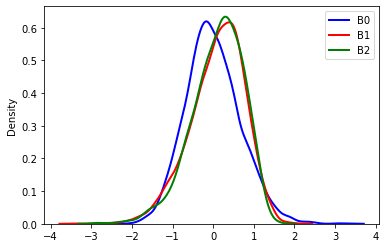

In [6]:
# Plot of the mean of generated phynotype

ax=sns.kdeplot(B0,color='b',label='B0',linewidth=2)
ax=sns.kdeplot(B1,color='r',label='B1',linewidth=2)
ax=sns.kdeplot(B2,color='g',label='B2',linewidth=2)
ax.legend()

In [7]:
# Computing standard error for each phynotype group

y_obs0_bar=np.mean(y_obs0)
Sy0 = np.sum(y_obs0*y_obs0)-N0*y_obs0_bar*y_obs0_bar
SEy0= np.sqrt(Sy0/(N0-1))

y_obs1_bar=np.mean(y_obs1)
Sy1 = np.sum(y_obs1*y_obs1)-N1*y_obs1_bar*y_obs1_bar
SEy1= np.sqrt(Sy1/(N1-1))

y_obs2_bar=np.mean(y_obs2)
Sy2 = np.sum(y_obs2*y_obs2)-N2*y_obs2_bar*y_obs2_bar
SEy2= np.sqrt(Sy2/(N2-1))

y=np.concatenate((y_obs0, y_obs1,y_obs2), axis=None) 

Xs=np.concatenate((Xs0,Xs1,Xs2), axis=None) 
print(SEy0)
print(SEy1)
print(SEy2)

0.672443571969705
0.6703293463318245
0.6348726917684078


Parametrs =  0.008168837793502665 [0.07283526]


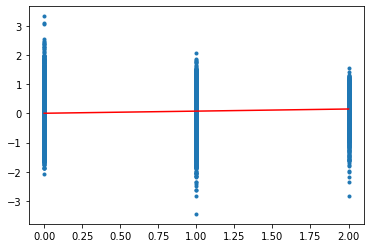

In [12]:
# Plot of GWAS (Regression) for the SNP and phynotype vectors

lin_reg= sklearn.linear_model.LinearRegression()
lin_reg.fit(np.c_[Xs],y)
print('Parametrs = ', lin_reg.intercept_ ,  lin_reg.coef_)

plt.plot(Xs, y,'.');
plt.plot(np.array([0, 2]), lin_reg.predict(np.c_[np.array([0,2])]), color='r');

In [13]:
# Regresssion summery for GWAS

X = sm.add_constant(Xs)
est = sm.OLS(y, X)
est2 = est.fit()
print(est2.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     50.18
Date:                Mon, 05 Dec 2022   Prob (F-statistic):           1.50e-12
Time:                        14:36:15   Log-Likelihood:                -10160.
No. Observations:               10000   AIC:                         2.032e+04
Df Residuals:                    9998   BIC:                         2.034e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0082      0.009      0.891      0.3

In [14]:
# GWAS P_Value

est2.pvalues[1]

1.4999652624410755e-12

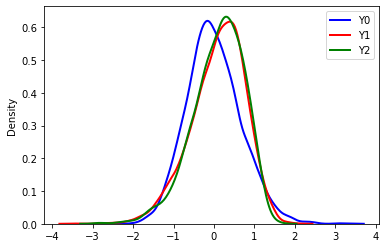

In [15]:
# Plot of the three phynotype group

ax=sns.kdeplot(y_obs0,color='b',label='Y0',linewidth=2)
ax=sns.kdeplot(y_obs1,color='r',label='Y1',linewidth=2)
ax=sns.kdeplot(y_obs2,color='g',label='Y2',linewidth=2)
ax.legend()

In [16]:
# Generating initial Betas for each group

seedinit4 = seedinit3+1
np.random.seed(seedinit4)
Beta0=norm.rvs(loc=y_obs0_bar, scale=SEy0,size=N0)
Beta1=norm.rvs(loc=y_obs1_bar, scale=SEy1,size=N1)
Beta2=norm.rvs(loc=y_obs2_bar, scale=SEy2,size=N2)

In [18]:
# Generating initial errors for each group

seedinit5 = seedinit4+1
np.random.seed(seedinit5)
eps0=np.random.normal(0,.35,size=N0)
eps1=np.random.normal(0,.35,size=N1)
eps2=np.random.normal(0,.35,size=N2)

In [19]:
# Initial phynotype for each group
y_initi0=Beta0+eps0
y_initi1=Beta1+eps1
y_initi2=Beta2+eps2

# Estimating the probability density function for each initial phynotype group
kde_y_initi0 = GKDE(y_initi0)
kde_y_initi1 = GKDE(y_initi1)
kde_y_initi2 = GKDE(y_initi2)

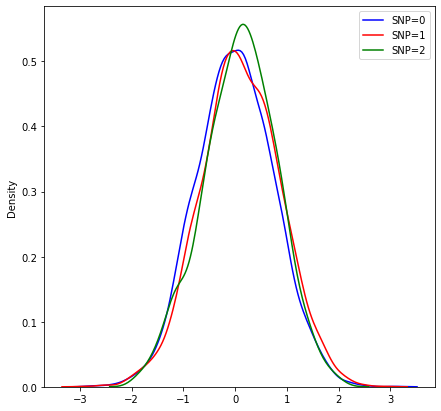

In [20]:
plt.figure(figsize=[7,7])

ax=sns.kdeplot(y_initi0,color='b',label='SNP=0',alpha=0.5)
ax=sns.kdeplot(y_initi1,color='r',label='SNP=1')
ax=sns.kdeplot(y_initi2,color='g',label='SNP=2')
ax.legend()

In [21]:
# Rejection sampling function to update initials
# Creating indexes for samples to keep from initial samples using rejection sampling 

def rejection_sampling(r):  
    N = r.size 
    seedinit6 = seedinit5+1
    np.random.seed(seedinit6)
    reject_prob = np.random.uniform(low=0, high=1, size=N) 
    r = r/np.max(r)
    idx = np.where(r >= reject_prob)[0]
    return idx

In [22]:
# Computing RN weight

r0=np.divide(kde_y_obs0(y_initi0),kde_y_initi0(y_initi0))
r1=np.divide(kde_y_obs1(y_initi1),kde_y_initi1(y_initi1))
r2=np.divide(kde_y_obs2(y_initi2),kde_y_initi2(y_initi2))

In [23]:
# Performing rejection sampling
samples_to_keep0 = rejection_sampling(r0)
samples_to_keep1 = rejection_sampling(r1)
samples_to_keep2 = rejection_sampling(r2)

# Computing acceptance rate from performing rejection sampling
accept_rate0 = samples_to_keep0.size/Beta0.shape[0] 
accept_rate1 = samples_to_keep1.size/Beta1.shape[0]
accept_rate2 = samples_to_keep2.size/Beta2.shape[0]


print(accept_rate0)  
print()
print(accept_rate1)
print()
print(accept_rate2)
print()

print(np.mean(r0))
print()
print(np.mean(r1))
print()
print(np.mean(r2))

0.4216742644011604

0.7386497294754175

0.7919826652221018

1.0027295639036367

1.0029277221749746

1.0030430349102466


In [24]:
# Samples of updated Beta
updated_Beta0 =Beta0[samples_to_keep0] 
updated_Beta1 =Beta1[samples_to_keep1]
updated_Beta2 =Beta2[samples_to_keep2]

# Updated Beta density
updated_y0 =y_initi0[samples_to_keep0] 
updated_y1 =y_initi1[samples_to_keep1] 
updated_y2 =y_initi2[samples_to_keep2] 

# Samples of updated phynotype
kde_updated_y0 = GKDE(y_initi0, weights=r0)
kde_updated_y1 = GKDE(y_initi1, weights=r1)
kde_updated_y2 = GKDE(y_initi2, weights=r2) # updated QoI density

# Updated phynotype density
kde_updated_Beta0 = GKDE(Beta0, weights=r0)
kde_updated_Beta1 = GKDE(Beta1, weights=r1)
kde_updated_Beta2 = GKDE(Beta2, weights=r2)

In [25]:
# Samples of updated error
updated_eps0 =eps0[samples_to_keep0]
updated_eps1 =eps1[samples_to_keep1] 
updated_eps2 =eps2[samples_to_keep2]

# Updated error density
kde_updated_eps0 = GKDE(eps0, weights=r0)
kde_updated_eps1 = GKDE(eps1, weights=r1)
kde_updated_eps2 = GKDE(eps2, weights=r2)

In [26]:
# Performing kruskal wallis test on updated means

stats.kruskal(updated_Beta0, updated_Beta1, updated_Beta2)

KruskalResult(statistic=67.77320698863696, pvalue=1.919707634202924e-15)

### Repeating the Simulation 200 times to test the accuracy of the method

In [27]:
# Generating 200 SNP Vectors randomly for 15% < MAF < 50% 

nSamp = 10000
nIter = 200
seedinit1 = 1
ac1=np.zeros((nSamp,nIter))
ac2=np.zeros((nSamp,nIter))
CV=np.zeros(nIter)
for j in range(nIter):
    seedinit1 = seedinit1 + j
    np.random.seed(seedinit1)
    CV[j]=np.random.uniform(0.15,0.5,1)
    
    unifc1=np.random.uniform(0,1,nSamp)
    unifc2=np.random.uniform(0,1,nSamp)
    
    for i in range(nSamp):
        if unifc1[i] <= CV[j]:
            ac1[i,j]=1
            
    for k in range(nSamp):
        if unifc2[k] <= CV[j]:
            ac2[k,j]=1
            
Xs=ac1+ac2
Xs.shape

(10000, 200)

In [28]:
# Computing the number of each SNP group "0", "1", "2" for each Xs

N=np.zeros((3,nIter))

for j in range(nIter):
    for i in range(nSamp):
        if Xs[i,j]==0 :
            N[0,j]+= 1
        elif Xs[i,j]==1:
            N[1,j] += 1
        else:
            N[2,j]+= 1

In [29]:
# Computing standard error for each Xs 

Xs_bar = np.zeros(nIter)
SEb = np.zeros(nIter)
SEe=np.zeros(nIter)
for j in range(nIter):
    Xs_bar[j]=np.mean(Xs[:,j])
    Sxx = np.sum(Xs[:,j]*Xs[:,j])-nSamp*Xs_bar[j]*Xs_bar[j]
    sigma=.9
    SEb[j]= np.sqrt(sigma/Sxx)
    SEe[j]=.9-SEb[j]

In [30]:
# First generate the mean and error for each phynotype group

B = np.zeros((nSamp,nIter))
e = np.zeros((nSamp,nIter))
y_obs= np.zeros((nSamp,nIter))
seedinit2 = seedinit1+1
for j in range(nIter):    
    seedinit2 = seedinit2+j
    np.random.seed(seedinit2)
    alpha=np.random.uniform(0,0.3,1)
    s=np.random.uniform(0,1.5,1)
    B[0:int(N[0,j]),j] = skewnorm.rvs(1.5,loc=-.5878, scale=.9, size=int(N[0,j]))
    B[int(N[0,j]):int(N[0,j])+int(N[1,j]),j] = skewnorm.rvs(-2.5,loc=.833, scale=1, size=int(N[1,j]))
    B[int(N[0,j])+int(N[1,j]):nSamp,j] = skewnorm.rvs(-3,loc=.8756 , scale=1, size=int(N[2,j]))
    
    e[0:int(N[0,j]),j]=np.random.normal(0,SEb[j],size=int(N[0,j]))
    e[int(N[0,j]):int(N[0,j])+int(N[1,j]),j]=np.random.normal(0, SEb[j],size=int(N[1,j]))
    e[int(N[1,j])+int(N[0,j]):nSamp,j]=np.random.normal(0,SEb[j],size=int(N[2,j]))
    
y_obs=B+e

In [31]:
# Computing Standard Error for each Phynotype group

y_obs_bar = np.zeros((3,nIter))
SEy=np.zeros((3,nIter))
Sy=np.zeros(3)
for j in range(nIter):
        y_obs_bar[0,j]=np.mean(y_obs[0:int(N[0,j]),j])
        y_obs_bar[1,j]=np.mean(y_obs[int(N[0,j]):int(N[1,j])+int(N[0,j]),j])
        y_obs_bar[2,j]=np.mean(y_obs[int(N[1,j])+int(N[0,j]):nSamp,j])
        Sy[0]= np.sum(y_obs[0:int(N[0,j]),j]*y_obs[0:int(N[0,j]),j])-N[0,j]*y_obs_bar[0,j]*y_obs_bar[0,j]
        Sy[1]= np.sum(y_obs[int(N[0,j]):int(N[0,j])+int(N[1,j]),j]*y_obs[int(N[0,j]):int(N[1,j])+int(N[0,j]),j])-N[1,j]*y_obs_bar[1,j]*y_obs_bar[1,j]
        Sy[2]= np.sum(y_obs[int(N[1,j])+int(N[0,j]):nSamp,j]*y_obs[int(N[1,j])+int(N[0,j]):nSamp,j])-N[2,j]*y_obs_bar[2,j]*y_obs_bar[2,j]
        SEy[0,j]= np.sqrt(Sy[0]/(int(N[0,j])-1))
        SEy[1,j]= np.sqrt(Sy[1]/(int(N[1,j])-1))
        SEy[2,j]= np.sqrt(Sy[2]/(int(N[2,j])-1))

In [32]:
# Generating initial beta and error for each group

Beta = np.zeros((nSamp,nIter))
eps = np.zeros((nSamp,nIter))
y_initi= np.zeros((nSamp,nIter))
seedinit3 = seedinit2+1
for j in range(nIter):    
    seedinit3 = seedinit3+j
    np.random.seed(seedinit3)
    Beta[0:int(N[0,j]),j] = norm.rvs(loc= y_obs_bar[0,j] , scale=SEy[0,j], size=int(N[0,j]))
    Beta[int(N[0,j]):int(N[1,j])+int(N[0,j]),j] = norm.rvs(loc= y_obs_bar[1,j], scale=SEy[1,j], size=int(N[1,j]))
    Beta[int(N[1,j])+int(N[0,j]):nSamp,j] = norm.rvs(loc= y_obs_bar[2,j] , scale=SEy[2,j], size=int(N[2,j]))
    
    eps[0:int(N[0,j]),j]=np.random.normal(0,.35,size=int(N[0,j]))
    eps[int(N[0,j]):int(N[1,j])+int(N[0,j]),j]=np.random.normal(0,.35,size=int(N[1,j]))
    eps[int(N[1,j])+int(N[0,j]):nSamp,j]=np.random.normal(0,.35,size=int(N[2,j]))
    
y_initi=Beta+eps

In [33]:
# Computing RN weights

r = np.zeros((nSamp,nIter))
for j in range(nIter):
            kde_y_obs0=GKDE(y_obs[0:int(N[0,j]),j])
            kde_y_initi0=GKDE(y_initi[0:int(N[0,j]),j])
            r[0:int(N[0,j]),j]=np.divide(kde_y_obs0(y_initi[0:int(N[0,j]),j]),kde_y_initi0(y_initi[0:int(N[0,j]),j]))
            kde_y_obs1=GKDE(y_obs[int(N[0,j]):int(N[1,j])+int(N[0,j]),j])
            kde_y_initi1=GKDE(y_initi[int(N[0,j]):int(N[1,j])+int(N[0,j]),j])
            r[int(N[0,j]):int(N[1,j])+int(N[0,j]),j]=np.divide(kde_y_obs1(y_initi[int(N[0,j]):int(N[1,j])+int(N[0,j]),j]),kde_y_initi1(y_initi[int(N[0,j]):int(N[1,j])+int(N[0,j]),j]))
            kde_y_obs2=GKDE(y_obs[int(N[1,j])+int(N[0,j]):nSamp,j])
            kde_y_initi2=GKDE(y_initi[int(N[0,j])+int(N[1,j]):nSamp,j])
            r[int(N[0,j])+int(N[1,j]):nSamp,j]=np.divide(kde_y_obs2(y_initi[int(N[0,j])+int(N[1,j]):nSamp,j]),kde_y_initi2(y_initi[int(N[0,j])+int(N[1,j]):nSamp,j]))
            

In [34]:
# Rejection sampling function to update initials
# Creating indexes for samples to keep from initial samples using rejection sampling 

def rejection_sampling(r): 
    N = r.size 
    seedinit4 = seedinit3+1
    np.random.seed(seedinit4)
    reject_prob = np.random.uniform(low=0, high=1, size=N) 
    r = r/np.max(r)
    idx = np.where(r >= reject_prob)[0]
    return idx

In [35]:
# Computing rejection sampling size

samples_to_keepSize=np.zeros((3,nIter))
accept_rate=np.zeros((3,nIter))
for j in range(nIter):
    samples_to_keepSize[0,j] = rejection_sampling(r[0:int(N[0,j]),j]).size
    samples_to_keepSize[1,j]=rejection_sampling(r[int(N[0,j]):int(N[1,j])+int(N[0,j]),j]).size
    samples_to_keepSize[2,j] = rejection_sampling(r[int(N[1,j])+int(N[0,j]):nSamp,j]).size

# Computing acceptance rate from performing rejection sampling
    accept_rate[0,j] = samples_to_keepSize[0,j]/N[0,j]
    accept_rate[1,j] = samples_to_keepSize[1,j]/N[1,j]
    accept_rate[2,j] = samples_to_keepSize[2,j]/N[2,j]

In [36]:
# Performing rejection sampling

samples_to_keep=np.zeros((nSamp,nIter))

for j in range(nIter):
    samples_to_keep[0:int(samples_to_keepSize[0,j]),j]= rejection_sampling(r[0:int(N[0,j]),j])
    samples_to_keep[int(samples_to_keepSize[0,j]):int(samples_to_keepSize[0,j])+int(samples_to_keepSize[1,j]),j]= rejection_sampling(r[int(N[0,j]):int(N[0,j])+int(N[1,j]),j])+int(N[0,j])
    samples_to_keep[int(samples_to_keepSize[0,j])+int(samples_to_keepSize[1,j]):int(samples_to_keepSize[0,j])+int(samples_to_keepSize[1,j])+int(samples_to_keepSize[2,j]),j]= rejection_sampling(r[int(N[0,j])+int(N[1,j]):nSamp,j])+int(N[0,j])+int(N[1,j])
    
    

In [37]:
# Samples from updated Beta, phynotype, and error

updated_Beta=np.zeros((nSamp,nIter))
updated_y=np.zeros((nSamp,nIter))
updated_eps=np.zeros((nSamp,nIter))
for j in range(nIter):
    updated_Beta[0:int(samples_to_keepSize[0,j]),j] =Beta[samples_to_keep[0:int(samples_to_keepSize[0,j]),j].astype(int),j]
    updated_Beta[int(samples_to_keepSize[0,j]):int(samples_to_keepSize[0,j])+int(samples_to_keepSize[1,j]),j] =Beta[samples_to_keep[int(samples_to_keepSize[0,j]):int(samples_to_keepSize[0,j])+int(samples_to_keepSize[1,j]),j].astype(int),j]
    updated_Beta[int(samples_to_keepSize[0,j])+int(samples_to_keepSize[1,j]):int(samples_to_keepSize[0,j])+int(samples_to_keepSize[1,j])+int(samples_to_keepSize[2,j]),j] =Beta[samples_to_keep[int(samples_to_keepSize[0,j])+int(samples_to_keepSize[1,j]):int(samples_to_keepSize[0,j])+int(samples_to_keepSize[1,j])+int(samples_to_keepSize[2,j]),j].astype(int),j]
    
    updated_y[0:int(samples_to_keepSize[0,j]),j] =y_initi[samples_to_keep[0:int(samples_to_keepSize[0,j]),j].astype(int),j]
    updated_y[int(samples_to_keepSize[0,j]):int(samples_to_keepSize[0,j])+int(samples_to_keepSize[1,j]),j] =y_initi[samples_to_keep[int(samples_to_keepSize[0,j]):int(samples_to_keepSize[0,j])+int(samples_to_keepSize[1,j]),j].astype(int),j]
    updated_y[int(samples_to_keepSize[0,j])+int(samples_to_keepSize[1,j]):int(samples_to_keepSize[0,j])+int(samples_to_keepSize[1,j])+int(samples_to_keepSize[2,j]),j] =y_initi[samples_to_keep[int(samples_to_keepSize[0,j])+int(samples_to_keepSize[1,j]):int(samples_to_keepSize[0,j])+int(samples_to_keepSize[1,j])+int(samples_to_keepSize[2,j]),j].astype(int),j]
    
    updated_eps[0:int(samples_to_keepSize[0,j]),j] =eps[samples_to_keep[0:int(samples_to_keepSize[0,j]),j].astype(int),j]
    updated_eps[int(samples_to_keepSize[0,j]):int(samples_to_keepSize[0,j])+int(samples_to_keepSize[1,j]),j] =eps[samples_to_keep[int(samples_to_keepSize[0,j]):int(samples_to_keepSize[0,j])+int(samples_to_keepSize[1,j]),j].astype(int),j]
    updated_eps[int(samples_to_keepSize[0,j])+int(samples_to_keepSize[1,j]):int(samples_to_keepSize[0,j])+int(samples_to_keepSize[1,j])+int(samples_to_keepSize[2,j]),j] =eps[samples_to_keep[int(samples_to_keepSize[0,j])+int(samples_to_keepSize[1,j]):int(samples_to_keepSize[0,j])+int(samples_to_keepSize[1,j])+int(samples_to_keepSize[2,j]),j].astype(int),j]
    
    

In [38]:
# Performing kruskal wallis test on updated means model

KruskalStatUp=np.zeros(nIter)
KruskalPvalueUp=np.zeros(nIter)
for j in range(nIter):
    KruskalStatUp[j]=stats.kruskal(updated_Beta[0:int(samples_to_keepSize[0,j]),j], updated_Beta[int(samples_to_keepSize[0,j]):int(samples_to_keepSize[0,j])+int(samples_to_keepSize[1,j]),j],updated_Beta[int(samples_to_keepSize[0,j])+int(samples_to_keepSize[1,j]):int(samples_to_keepSize[0,j])+int(samples_to_keepSize[1,j])+int(samples_to_keepSize[2,j]),j])[0]
    KruskalPvalueUp[j]=stats.kruskal(updated_Beta[0:int(samples_to_keepSize[0,j]),j], updated_Beta[int(samples_to_keepSize[0,j]):int(samples_to_keepSize[0,j])+int(samples_to_keepSize[1,j]),j],updated_Beta[int(samples_to_keepSize[0,j])+int(samples_to_keepSize[1,j]):int(samples_to_keepSize[0,j])+int(samples_to_keepSize[1,j])+int(samples_to_keepSize[2,j]),j])[1]
    

In [39]:
# kruskal wallis Maximum P-vlaue

KruskalPvalueUp.max()

0.00014192981247251925

In [40]:
# kruskal wallis minimum  P-vlaue

KruskalPvalueUp.min()

3.063056387735181e-36

In [41]:
# Number of non-significant kruskal wallis P-values

(KruskalPvalueUp >.00000005).sum()

14

In [43]:
# Putting three SNPs vector in the same vector to perform regression

for j in range(nIter):
    index0=np.where(Xs[:,j] == 0)
    index1=np.where(Xs[:,j] == 1)
    index2=np.where(Xs[:,j] == 2)
    Xs0=Xs[:,j][index0]
    Xs1=Xs[:,j][index1]
    Xs2=Xs[:,j][index2]
    Xs[:,j]=np.concatenate((Xs0,Xs1,Xs2), axis=None) 

In [44]:
# Performing regression on 200 simulated SNP vectors and phynotype vectors 

OLS_Pvalues=np.zeros(nIter)
for j in range(nIter):
    X=sm.add_constant(Xs[:,j])
    est=sm.OLS(y_obs[:,j],X).fit()
    OLS_Pvalues[j]=est.pvalues[1]



In [45]:
# GWAS maximum P-vlaue

OLS_Pvalues.max()

0.0009288640970996567

In [46]:
# Number of non-significant GWAS P-values

(OLS_Pvalues >.00000005).sum()

51

In [51]:
# GWAS minimum P-vlaue

OLS_Pvalues.min()

1.0835134807259611e-27